In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import matplotlib.dates as mdates
%matplotlib inline

import datetime as dt
import time
import yfinance as yf
import math
from scipy.stats import norm

import os
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


cf.go_offline()

from plotly.subplots import make_subplots

import warnings
warnings.simplefilter("ignore")

In [3]:
from pytz import timezone
from datetime import datetime

def format(dat, tz):
  return dat.astimezone(tz).isoformat() # or strftime

tz = timezone("America/New_York")
dat = datetime.fromtimestamp(1647642342)

format(dat, tz)
sdate = format(dt.datetime(2022, 4, 1), tz)

In [12]:
companies = ['ET', 'KMI', 'EPD', 'WMB', 'OKE', 'PAA', 'TRGP']

In [13]:
data = {}
for ticker in companies:
    print(f"Getting data for {ticker}")
    data[ticker] = yf.Ticker(ticker).history(period="5y")
    data[ticker] = data[ticker].loc[data[ticker].index >= sdate]
    print("Done")
    time.sleep(2)

Getting data for ET
Done
Getting data for KMI
Done
Getting data for EPD
Done
Getting data for WMB
Done
Getting data for OKE
Done
Getting data for PAA
Done
Getting data for TRGP
Done


In [14]:
fig = go.Figure()
ticker = 'ET'
candle = go.Candlestick(x=data[ticker].index, high=data[ticker].High, low=data[ticker].Low, open=data[ticker].Open, close=data[ticker].Close)
fig.add_trace(candle)
fig.update_layout(
    margin=dict(l=0, r=5, t=5, b=5),
    yaxis_title = "US$"
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [15]:
S_YEAR = [2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2024, 2024, 2024, 2024, 2024, 2024]
E_YEAR = [2022, 2022, 2022, 2022, 2022, 2022, 2022, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2024, 2024, 2024, 2024, 2024, 2024, 2024]
S_MONTH = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5]
E_MONTH = [6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]

dates = []
for i in range(25):
    dates.append(f"{S_YEAR[i]}-{S_MONTH[i]}")

monthly_data = {}
for ticker in companies:
    df = data[ticker]
    high = []
    low = []
    open = []
    close = []
    volume = []
    for i in range(25):
        sdate = format(dt.datetime(S_YEAR[i], S_MONTH[i], 1), tz)
        edate = format(dt.datetime(E_YEAR[i], E_MONTH[i], 1), tz)
        high.append(max(df.loc[(df.index >= sdate) & (df.index <= edate)]['Close']))
        low.append(min(df.loc[(df.index >= sdate) & (df.index <= edate)]['Close']))
        open.append(df.loc[(df.index >= sdate) & (df.index <= edate)].iloc[0]['Close'])
        close.append(df.loc[(df.index >= sdate) & (df.index <= edate)].iloc[-1]['Close'])
        volume.append(sum(df.loc[(df.index >= sdate) & (df.index <= edate)]['Volume']))
    df = pd.DataFrame(list(zip(dates, high, low, open, close, volume)),
               columns =['MONTH', 'High', 'Low', 'Open', 'Close', 'Volume'])
    monthly_data[ticker] = df

In [16]:
fig = go.Figure()
ticker = 'ET'
candle = go.Candlestick(x=monthly_data[ticker].MONTH, high=monthly_data[ticker].High, low=monthly_data[ticker].Low, open=monthly_data[ticker].Open, close=monthly_data[ticker].Close)
fig.add_trace(candle)
fig.update_layout(
    margin=dict(l=0, r=5, t=5, b=0),
    xaxis_title = "Month",
    yaxis_title = "US$"
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

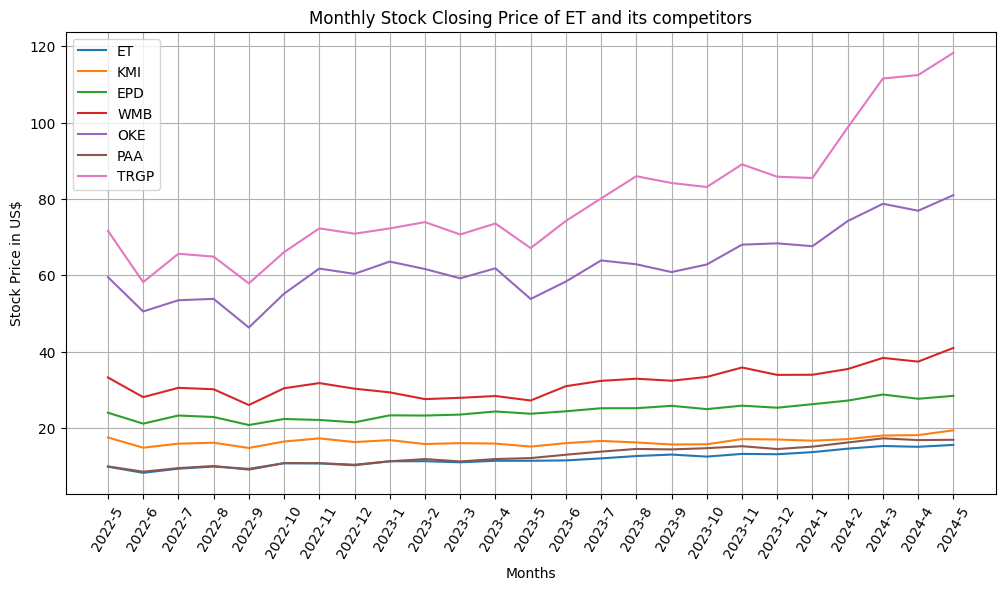

In [17]:
plt.figure(figsize=(12, 6))
for ticker in companies:
    plt.plot(dates, monthly_data[ticker]['Close'], label=ticker)
plt.legend()
plt.xticks(rotation=60)
plt.title("Monthly Stock Closing Price of ET and its competitors")
plt.ylabel("Stock Price in US$")
plt.xlabel("Months")
plt.grid()

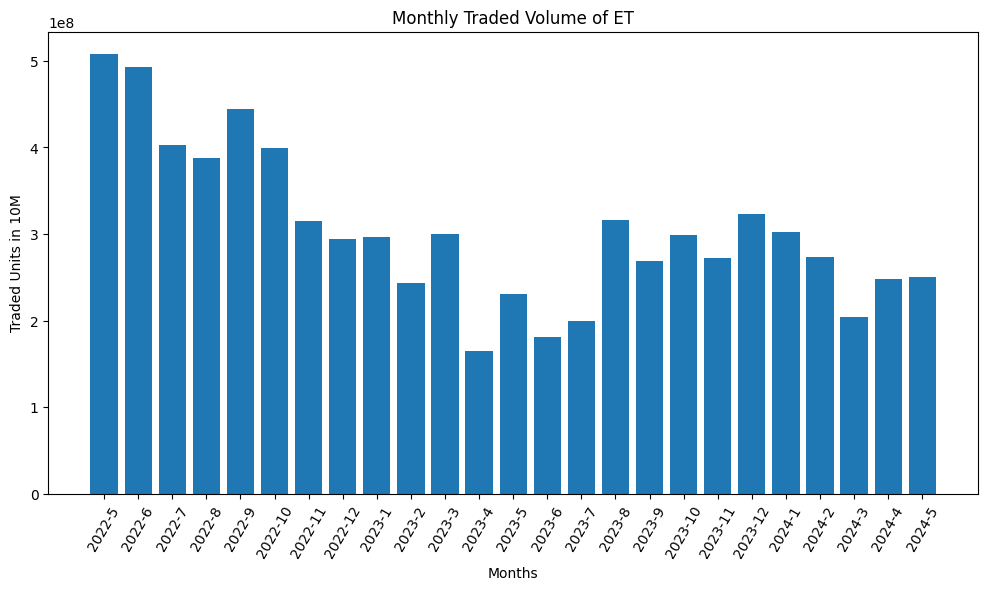

In [46]:
plt.figure(figsize=(12, 6))
plt.bar(dates, monthly_data['ET']['Volume'])
plt.xticks(rotation=60)
plt.title("Monthly Traded Volume of ET")
plt.ylabel("Traded Units in 10M")
plt.xlabel("Months")
plt.show()

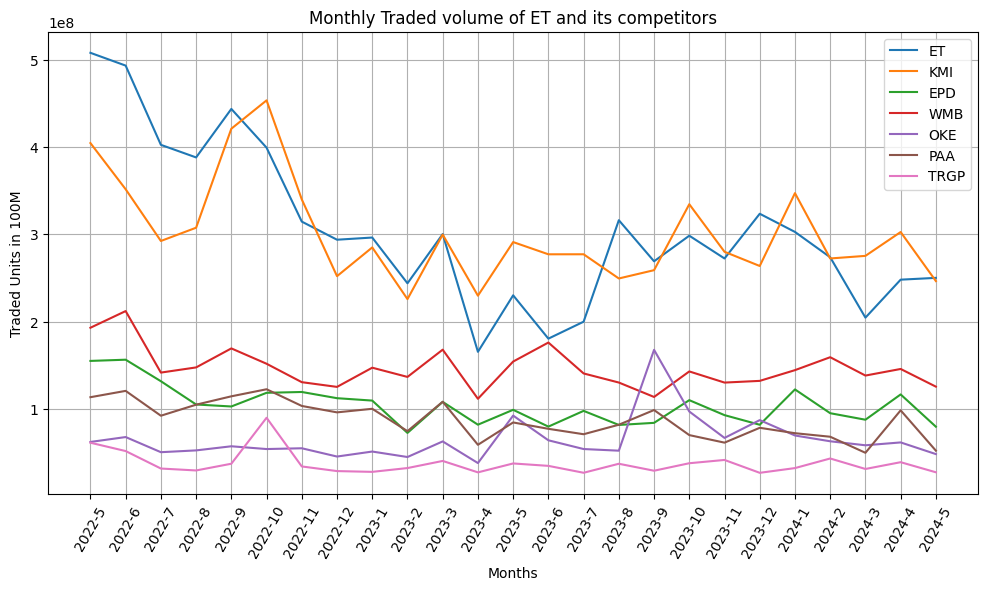

In [21]:
plt.figure(figsize=(12, 6))
for ticker in companies:
    plt.plot(dates, monthly_data[ticker]['Volume'], label=ticker)
plt.legend()
plt.xticks(rotation=60)
plt.title("Monthly Traded volume of ET and its competitors")
plt.ylabel("Traded Units in 100M")
plt.xlabel("Months")
plt.grid()

In [23]:
def bollinger_bands(df):
    df['middle_band'] = df['Close'].rolling(window=20).mean()
    df['upper_band'] = df['middle_band'] + 1.96*df['Close'].rolling(window=20).std()
    df['lower_band'] = df['middle_band'] - 1.96*df['Close'].rolling(window=20).std()

df_ET = data['ET']
bollinger_bands(df_ET)

In [31]:
df = df_ET
fig = go.Figure()
candle = go.Candlestick(x=df.index, high=df.High, low=df.Low, open=df.Open, close=df.Close)
upper_line = go.Scatter(x=df.index, y=df['upper_band'],
                        line = dict(color='rgba(0, 0, 250, 0.75)', width = 1),
                        name = "Upper Band")
middle_line = go.Scatter(x =df.index, y=df['middle_band'],
                        line = dict(color='rgba(250, 0, 0, 0.75)', width = 0.75),
                        name = "Middle Band")
lower_line = go.Scatter(x=df.index, y=df['lower_band'],
                        line = dict(color='rgba(0, 250, 0, 0.75)', width = 1),
                        name = "Lower Band")
fig.add_trace(candle)
fig.add_trace(upper_line)
fig.add_trace(middle_line)
fig.add_trace(lower_line)
fig.update_layout(
    height=600,
    width=1100,
    margin=dict(l=0, r=5, t=5, b=5),
    yaxis_title = "ET Stock Closing Stock Price [$]"
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [33]:
T = 252
df['Temp1'] = np.log(df['Close']/df['Close'].shift(1))
m = df['Temp1'].sum()/df['Temp1'].count() 
    
#the variance of the notmal distribution E[(X - E[X])**2]
df['Temp2'] = np.power(df['Temp1'].sub(m), 2)
var = df['Temp2'].sum()/(df['Close'].count() - 1)
X0 = df['Close'].iloc[df['Close'].count() - 1]

stock_prob = (1 - norm.cdf(math.log(X0*1.1), loc = math.log(X0) + m*T, scale = math.sqrt(var*T)))*100

In [34]:
stock_prob

74.74024936995234

In [43]:
revenue = [21.63, 20.53, 20.74, 18.32, 19.00, 20.50, 22.94, 25.95, 20.49]
gross_profits = [5.03, 4.75, 4.68, 4.23, None, None , None , None , None    ]
net_income = [1.24, 1.33, 0.54,0.91, None, None , None , None , None] 
adjusted_EBIDTA = [115.2, 147.6, 106.5, 107, 110.7, 130.1, 100.1, 114.7, 94.4]
GAAP_EPS = [0.32, 0.37, 0.31, 0.25, 0.32, 0.34, 0.29, 0.39, 0.37]
time = ["Q1 '24", "Q4 '23", "Q3 '23", "Q2 '23", "Q1 '23", "Q4 '22", "Q3 '22", "Q2 '22", "Q1 '22"]

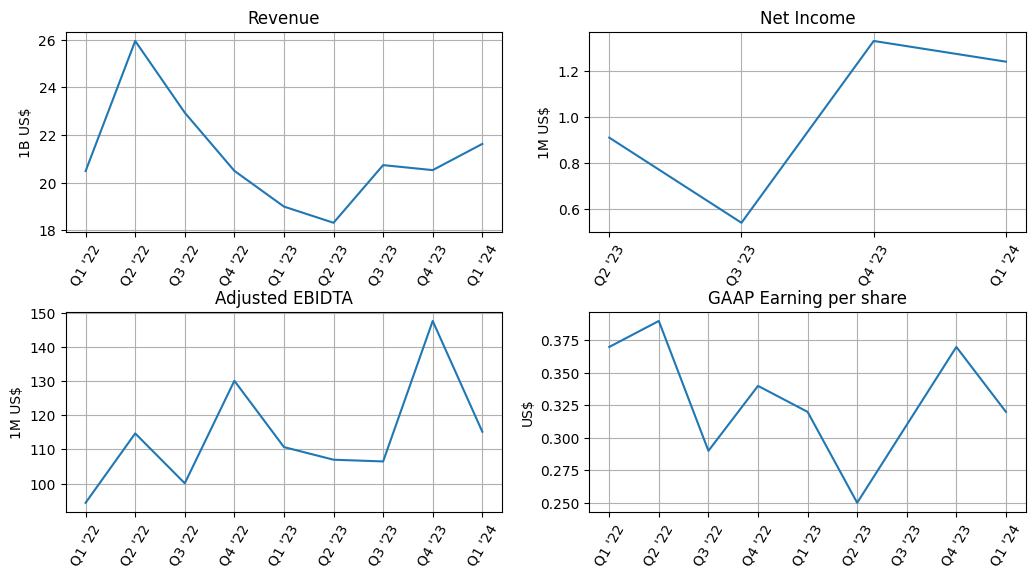

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(time[::-1], revenue[::-1])
plt.title("Revenue")
plt.ylabel("1B US$")
plt.xticks(rotation=60)
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(time[::-1], net_income[::-1])
plt.title("Net Income")
plt.ylabel("1M US$")
plt.xticks(rotation=60)
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(time[::-1], adjusted_EBIDTA[::-1])
plt.title("Adjusted EBIDTA")
plt.ylabel("1M US$")
plt.xticks(rotation=60)
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(time[::-1], GAAP_EPS[::-1])
plt.title("GAAP Earning per share")
plt.ylabel("US$")
plt.xticks(rotation=60)
plt.grid()

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
plt.show()